In [1]:
import os
import pandas as pd
import janitor
import numpy as np
pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid', palette='dark') #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from forestplot import forestplot
import matplotlib.ticker as mtick

def save_mpl_fig(savepath):
    plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
    plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)
    
DATAPATH = "../adult-data/output"        

In [2]:
# Read in list of classified FP (false positives)
falsepositives = (pd
                  .read_csv("../data/false_positives_list.csv")
                  ["flagged as FP"].tolist()
                 )
falsepositives

['9gag.com',
 'sniffies.com',
 'f95zone.to',
 'silverdaddies.com',
 'ttcache.com',
 'xlviirdr.com',
 '4chan.org',
 'thechive.com',
 'victoriassecret.com',
 'usasexguide.nl',
 'xlviiirdr.com',
 'xxxjmp.com',
 'urbandictionary.com',
 'lpsg.com']

In [3]:
# (fold cell) Load and prep web browsing data
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration", "visit_time_local"]
usecols = ["caseid", "category", "private_domain", "page_duration", "session_start_time"]

df = (pd.concat([
        # Get web_mobile
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_mobile_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ), 
        # Get web_desktop
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_desktop_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_2022-06-01_2022-06-30.csv"),
            usecols=usecols,
            low_memory=False,
        )
         # Renaming columns to be consistent w/ web_mobile & web_desktop
         .rename_column("session_start_time", "visit_time_local")
         .rename_column("page_duration", "visit_duration")
        )
        ])
     )
# print("output = df with visits to adult sites")
print(f"{len(df)=:,}")
df.head()

len(df)=6,297,382


,caseid,private_domain,category,visit_time_local,visit_duration
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457
2,205323077,google.com,Business,2022-06-01 01:15:12,55
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10


In [4]:
# (fold cell) Get adult sites metrics
df_adultsites_count = (df
                       .query("category.str.contains('adult', case=False, na=False)")
                       .query("private_domain not in @falsepositives")
                       .dropna(subset=["caseid", "category", "visit_duration"])
                       .groupby(["private_domain", "category"])
                       .size()
                       .reset_index()
                       .rename_column(0, "count")
                       .sort_values("count", ascending=False, ignore_index=True)
                       # Get total visit duration of websites
                       .merge((df
                               .groupby(["private_domain", "category"])
                               .visit_duration.sum()
                               .reset_index()
                               # Normalize from second(s) to hour(s)
                               .assign(visit_duration=lambda df: df.visit_duration/3600)
                               .round(decimals=0)
                               .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                              ), how="left", on=["private_domain", "category"], validate="1:1"
                             )                       
                       # Preparing for plot
                       .assign(ll=lambda df: df["count"])
                       .assign(hl=lambda df: df["count"])
                       # Format count and visit_duration
                       .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                       .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                       .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                       .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                       .assign(category=lambda df: df.category.apply(lambda x: x.rjust(46) if len(x)<46 else x))
                      )
df_adultsites_count.head()

,private_domain,category,count,visit_duration,ll,hl,count_str,visit_duration_str
0,xvideos.com,Adult,9368,311,9368,9368,"9,368",311
1,pornhub.com,Adult,7811,184,7811,7811,"7,811",184
2,xnxx.com,Adult,6540,207,6540,6540,"6,540",207
3,onlyfans.com,"Adult, Business",5805,53,5805,5805,"5,805",53
4,rule34.xxx,Adult,5797,35,5797,5797,"5,797",35


In [5]:
print((df_adultsites_count
 .head(100)
 .filter(["private_domain", "category", "count", "visit_duration"])
 .head(50)
 .to_markdown()
#  .to_csv("../data/top100_adultsites.csv", index=False)
))

|    | private_domain    | category               |   count |   visit_duration |
|---:|:------------------|:-----------------------|--------:|-----------------:|
|  0 | xvideos.com       | Adult                  |    9368 |              311 |
|  1 | pornhub.com       | Adult                  |    7811 |              184 |
|  2 | xnxx.com          | Adult                  |    6540 |              207 |
|  3 | onlyfans.com      | Adult, Business        |    5805 |               53 |
|  4 | rule34.xxx        | Adult                  |    5797 |               35 |
|  5 | fetlife.com       | Adult, Business        |    3577 |               10 |
|  6 | xhamster.com      | Adult                  |    3465 |              104 |
|  7 | chaturbate.com    | Adult                  |    2798 |               23 |
|  8 | motherless.com    | Adult                  |    2507 |               29 |
|  9 | literotica.com    | Adult                  |    2305 |               47 |
| 10 | myfreecams.com    | A

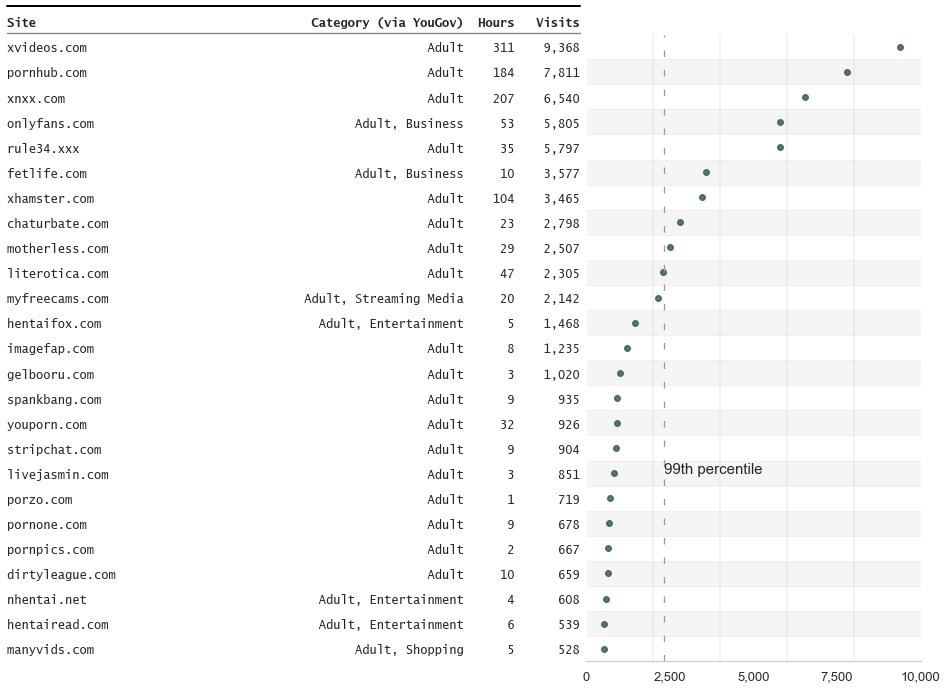

In [6]:
# Plot (fold cell)
ax = forestplot(df_adultsites_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
                annote=["category", "visit_duration_str", "count_str"],
                annoteheaders=[25*" " + "Category (via YouGov)", "Hours", " Visits"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,12_500,2_500),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [2000, 4000, 6000, 8000]:
    ax.vlines(vline, ymin=-.5, ymax=24.5, colors=".6", linewidth=.2)
annotation = "99th percentile"
p95 = df_adultsites_count["count"].quantile(q=.99)
horizontal_scaler = 1.05
x, y = horizontal_scaler*p95, 7
plt.annotate(annotation, (x, y), size=15)
plt.axvline(
    x, 
    ymax=.96, 
    color=".6", 
    ls=(0, (5, 10)), 
    lw=1.3
)
save_mpl_fig(os.path.join("../figs/top_25_adultsites"))

In [7]:
# (fold cell) Get non-adult sites metrics
df_nonadultsites_count = (df
                          .query("~category.str.contains('adult', case=False, na=False)")
                          .dropna(subset=["caseid", "category", "visit_duration"])
                          .groupby(["private_domain", "category"])
                          .size()
                          .reset_index()
                          .rename_column(0, "count")
                          .sort_values("count", ascending=False, ignore_index=True)
                          # Get total visit duration of websites
                          .merge((df
                                  .groupby(["private_domain", "category"])
                                  .visit_duration.sum()
                                  .reset_index()
                                  # Normalize from second(s) to hour(s)
                                  .assign(visit_duration=lambda df: df.visit_duration/3600)
                                  .round(decimals=0)
                                  .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                                 ), how="left", on=["private_domain", "category"], validate="1:1"
                                )
                          # Preparing for plot
                          .assign(ll=lambda df: df["count"])
                          .assign(hl=lambda df: df["count"])
                          # Format count and visit_duration
                          .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                          .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                          .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                          .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                          .assign(category=lambda df: df.category.apply(lambda x: x.rjust(42) if len(x)<42 else x))
                         )
df_nonadultsites_count.head()

,private_domain,category,count,visit_duration,ll,hl,count_str,visit_duration_str
0,google.com,Search Engines and Portals,628361,4135,628361,628361,"628,361","4,135"
1,facebook.com,"Business, Social Networking",443263,5701,443263,443263,"443,263","5,701"
2,google.com,Chat and Instant Messaging,278233,2664,278233,278233,"278,233","2,664"
3,bing.com,"News and Media, Search Engines and Portals",231155,1471,231155,231155,"231,155","1,471"
4,youtube.com,"Entertainment, Streaming Media",227981,4449,227981,227981,"227,981","4,449"


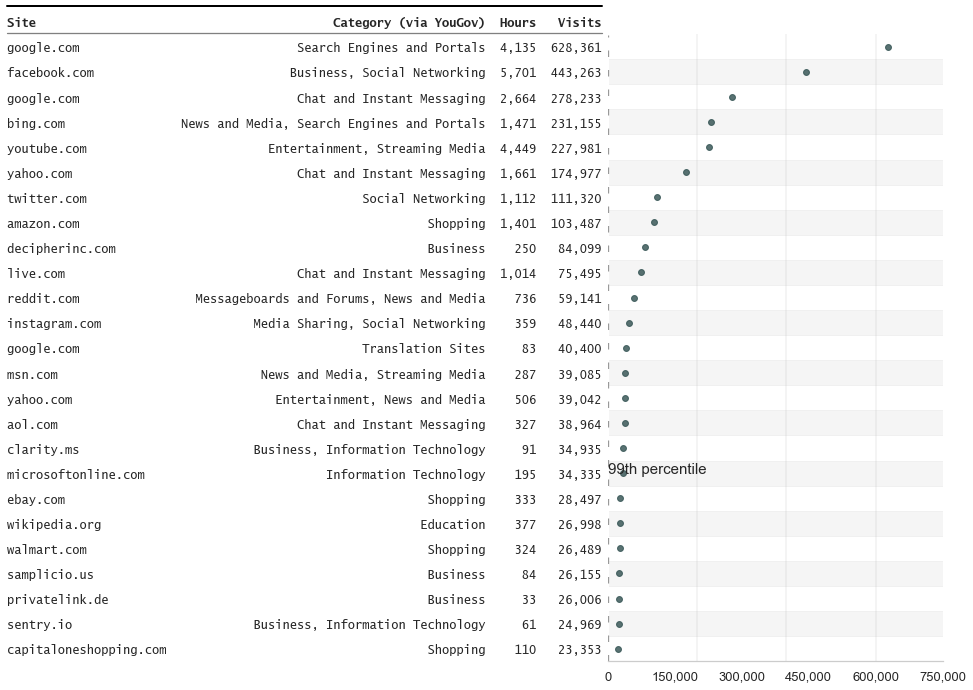

In [8]:
# Plot (fold cell)
ax = forestplot(df_nonadultsites_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
                annote=["category", "visit_duration_str", "count_str"],
                annoteheaders=[21*" " + "Category (via YouGov)", "Hours", " Visits"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,800_000,150_000),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [200_000, 400_000, 600_000]:
    ax.vlines(vline, ymin=-.5, ymax=24.5, colors=".6", linewidth=.2)
annotation = "99th percentile"
p95 = df_nonadultsites_count["count"].quantile(q=.99)
horizontal_scaler = 1.05
x, y = horizontal_scaler*p95, 7
plt.annotate(annotation, (x, y), size=15)
plt.axvline(
    x, 
    ymax=.96, 
    color=".6", 
    ls=(0, (5, 10)), 
    lw=1.3
)
save_mpl_fig(os.path.join("../figs/top_25_nonadultsites"))

In [9]:
df_zero_duration = (df
                    .query(f"visit_duration==0")
                    .groupby(["private_domain", "category"])
                    .size()
                    .reset_index()
                    .rename_column(0, "count")
                    .sort_values("count", ascending=False, ignore_index=True)
                   )
df_zero_duration.head(20)

,private_domain,category,count
0,google.com,Search Engines and Portals,40554
1,decipherinc.com,Business,33011
2,google.com,Translation Sites,17671
3,youtube.com,"Entertainment, Streaming Media",11766
4,dynata.com,Business,7733
5,facebook.com,"Business, Social Networking",7636
6,google.com,Chat and Instant Messaging,6997
7,amazon.com,Shopping,5604
8,google.com.mx,Translation Sites,5161
9,live.com,Chat and Instant Messaging,4366
